In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('../data/data_clean.csv', sep=',', encoding='latin-1')
df = df.drop(columns=['PAQ706'])
df = df.drop(columns = ['CDQ001', 'CDQ010', 'DIQ070', 'DBD100', 'highLDL'])

#variable choice to create dataset for missignness simulation
df_nonmiss = df[['SEQN','RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'RIDRETH3',
                 'DMDCITZN', 'DMDEDUC2', 'BMXLEG', 'BPXPULS',
                 'DIQ010', 'DIQ050', 'HIQ011', 'PAQ635', 
                 'PAQ650', 'PAQ665','PAD680', 'PAQ710', 'DR1TKCAL']]
cont_cols = ['RIDAGEYR', 'BMXLEG', 'DR1TKCAL', 'PAD680']
# Normalize continuous columns to standard Normal 
for cont_col in cont_cols: 
    df_nonmiss[cont_col] = (df_nonmiss[cont_col] - df_nonmiss[cont_col].mean()) / df_nonmiss[cont_col].std() 


np_nonmiss = df_nonmiss.to_numpy(copy=True, na_value=np.nan) # Convert dataframe to numpy array 
np_nonmiss = np_nonmiss[~np.isnan(np_nonmiss).any(axis=1), :] # delete rows with any missing values

seqn = np_nonmiss[:, 0] #record seqn for rows in df_nonmiss
np_nonmiss = np_nonmiss[:, 1:18] #remove seqn
print(np.shape(np_nonmiss))

(4749, 17)


/var/folders/_1/dc2yd0kn325bph09grgy33lr0000gn/T/ipykernel_96889/2370860991.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonmiss[cont_col] = (df_nonmiss[cont_col] - df_nonmiss[cont_col].mean()) / df_nonmiss[cont_col].std()


In [3]:
#proportion missing
p = 0.1 

#MCAR
MCAR_data = np_nonmiss #init data
MCAR_missing_indices = np.random.choice( # randomly select values from length ie flat array 
    len(np_nonmiss.flatten()), 
    size=int(len(np_nonmiss.flatten())*p)) 

MCAR_data.flat[MCAR_missing_indices] = np.nan 

In [4]:
MNAR_data = np_nonmiss #init data

#find bmi values
bmi = df.loc[df['SEQN'].isin(seqn)]['bmi'] #limit to subset in seqn, select col bmi
bmi = bmi.to_numpy(copy=True, na_value=np.nan)

#high bmi
hibmi = (bmi > 25) #def of obesity
#health bmi
hebmi = (bmi < 25)

#determine indicies with hi or low bmi values
hibmi_ind = np.where(hibmi)[0]
hebmi_ind = np.where(hebmi)[0]

#randomly select indices for missing values
MNAR_missing_diet_ind = np.random.choice(len(hibmi_ind),
                                        size = round(len(hibmi_ind)*2*p/3)) #oversample hi bmi
np.append(MNAR_missing_diet_ind, 
          np.random.choice(len(hebmi_ind),
                           size = round(len(hebmi_ind)*p/3))) 

#remove those values from dataset
for i in MNAR_missing_diet_ind: 
    MNAR_data[i, 16] = np.nan #16 col is DR1TKCAL


In [5]:
#MAR

# When data are MAR, the fact that the data are missing is systematically related to the observed
# but not the unobserved data, eg. related to age 

MAR_data = np_nonmiss #init data

#determine indicies with PAQ values
PAQ1_ind = np.where(np_nonmiss[:, 12] == 1) #12 col is PAQ650
PAQ2_ind = np.where(np_nonmiss[:, 12] == 2)

#randomly select indices for missing values
MAR_missing_diet_ind = np.random.choice(len(PAQ1_ind[0]),
                                        size = round(len(PAQ1_ind[0])*p/3))
np.append(MAR_missing_diet_ind, 
          np.random.choice(len(PAQ2_ind[0]),
                           size = round(len(PAQ2_ind[0])*2*p/3))) #more PAQ=2 are missing

#remove those values from dataset
for i in MAR_missing_diet_ind: 
    MAR_data[i, 16] = np.nan #16 col is DR1TKCAL


In [6]:
matrix = MCAR_data 
matrix = MAR_data 
matrix = MNAR_data 

In [7]:
matrix.shape 

(4749, 17)

In [8]:
def fit_low_rank_model(rank, rating_matrix_ini, train_ind, train_data, n_iter, convergence_thresh, verbose):
    previous_fitting_error = 100
    low_rank_estimate = np.zeros(rating_matrix_ini.shape) - 1 
                
    for ind in range(n_iter): 
        M = low_rank_estimate.copy() 
        M.flat[train_ind] = rating_matrix_ini.flat[train_ind] 
        u, s, vh = np.linalg.svd(M) 
        low_rank_estimate = u[:, :rank] * s[:rank] @ vh[:rank, :]
        
        fitting_error = np.sqrt(np.mean(np.square(rating_matrix_ini.flat[train_ind] - 
                                                  low_rank_estimate.flat[train_ind])))         
        if verbose:
            print("Iteration " + str(ind) + " Error: " + str(fitting_error))
        
        if abs(fitting_error-previous_fitting_error) <= convergence_thresh: 
            print('Stopping at: ', ind)
            break 
        previous_fitting_error = fitting_error 
        
    return low_rank_estimate 

In [9]:
def run(matrix, 
        n_test = 100, 
        n_val = 100, 
        n_iter = 500,
        convergence_thresh=1e-3
       ): 
    n_train = matrix.shape[0] - n_test - n_val

    nonmissing_indices = np.argwhere(~np.isnan(matrix.flatten())).reshape(-1) 

    aux_ind = nonmissing_indices[np.random.permutation(np.arange(len(nonmissing_indices)))]
    test_ind = aux_ind[:n_test]
    val_ind = aux_ind[n_test:(n_test+n_val)]
    train_ind = aux_ind[(n_test+n_val):(n_test+n_val+n_train)]

    train_set = matrix.flat[train_ind] 
    val_set = matrix.flat[val_ind]
    test_set = matrix.flat[test_ind]

    # make imputed rating matrix (training data) as initialization
    matrix_ini = np.zeros(matrix.shape) - 1 
    matrix_ini.flat[train_ind] = train_set 

    ## Impute missing values with column mean to begin with 
    col_mean = [np.mean(col[col>-1]) for col in matrix_ini.T]
    inds = np.where(matrix_ini == -1) 
    matrix_ini[inds] = np.take(col_mean, inds[1]) 
        
    ranks = np.arange(1, 10, 1)
    train_error = np.zeros(len(ranks))
    val_error = np.zeros(len(ranks))
    
    for ind,rank in enumerate(ranks):
        print("Rank " + str(rank))
        estimate = fit_low_rank_model(rank, 
                                      matrix_ini, 
                                      train_ind, 
                                      train_set, 
                                      n_iter, 
                                      convergence_thresh, 
                                      verbose=False)

        train_error[ind] = np.sqrt(np.mean(np.square(train_set - estimate.flat[train_ind]))) 

        val_error[ind] = np.sqrt(np.mean(np.square(val_set - estimate.flat[val_ind]))) 

    markersize = 10
    font_size = 25
    font_size_ticks = 22
    plt.figure(figsize=(12,9))
    plt.plot(ranks, train_error, linestyle="None", marker='o', ms=markersize, color="black", markeredgewidth=2,
                         markerfacecolor="black",label="Training error")
    plt.plot(ranks, val_error, linestyle="None", marker='o', ms=markersize, color="black", markeredgewidth=2,
                         markerfacecolor="white", label="Validation error")
    plt.ylabel('Root mean squared error', fontsize=font_size, labelpad=10)
    plt.xlabel('Rank', fontsize=font_size, labelpad=10)
    plt.xticks(fontsize=font_size_ticks) 
    plt.yticks(fontsize=font_size_ticks)
    #plt.ylim([0,1.1])
    plt.legend(fontsize=font_size)
    plt.show() 
    # plt.savefig('plots/errors.pdf',bbox_inches="tight") 
    
    best_rank = np.argmin(val_error)+1  
    print('best_rank: ', best_rank)
    best_estimate = fit_low_rank_model(best_rank, 
                                       matrix_ini, 
                                       train_ind, 
                                       train_set, 
                                       n_iter, 
                                       convergence_thresh, 
                                       verbose=False)

    test_error = np.sqrt(np.mean(np.square(test_set - best_estimate.flat[test_ind]))) 
    print("Error of low-rank estimate: " + str(np.round(test_error,3))) 

    error_mean_rating = np.sqrt(np.mean(np.square(test_set - matrix_ini.flat[test_ind]))) 
    print("Error of mean estimate: " + str(np.round(error_mean_rating,3)))



Rank 1
Stopping at:  67
Rank 2
Stopping at:  77
Rank 3
Stopping at:  73
Rank 4
Stopping at:  55
Rank 5
Stopping at:  70
Rank 6
Stopping at:  60
Rank 7
Stopping at:  59
Rank 8
Stopping at:  55
Rank 9
Stopping at:  44


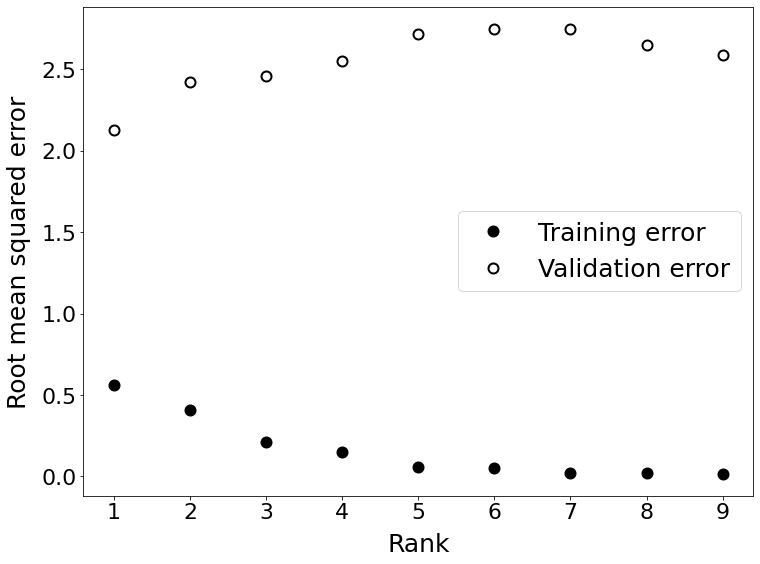

best_rank:  1
Stopping at:  67
Error of low-rank estimate: 1.924
Error of mean estimate: 0.85


In [10]:
run(matrix=MCAR_data)

Rank 1
Stopping at:  66
Rank 2
Stopping at:  97
Rank 3
Stopping at:  67
Rank 4
Stopping at:  55
Rank 5
Stopping at:  59
Rank 6
Stopping at:  69
Rank 7
Stopping at:  63
Rank 8
Stopping at:  54
Rank 9
Stopping at:  45


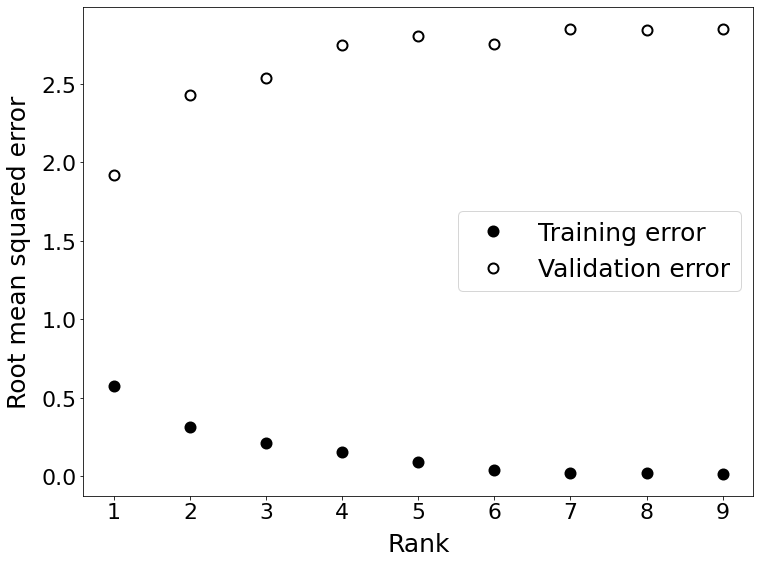

best_rank:  1
Stopping at:  66
Error of low-rank estimate: 2.702
Error of mean estimate: 0.96


In [11]:
run(matrix=MAR_data)

Rank 1
Stopping at:  66
Rank 2
Stopping at:  87
Rank 3
Stopping at:  52
Rank 4
Stopping at:  82
Rank 5
Stopping at:  66
Rank 6
Stopping at:  56
Rank 7
Stopping at:  51
Rank 8
Stopping at:  42
Rank 9
Stopping at:  38


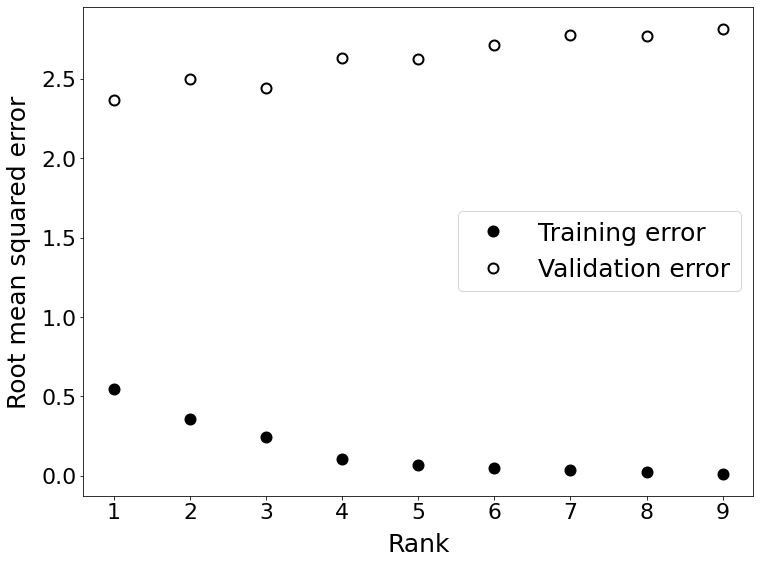

best_rank:  1
Stopping at:  66
Error of low-rank estimate: 2.104
Error of mean estimate: 0.788


In [12]:
run(matrix=MNAR_data)